Data processing complete.


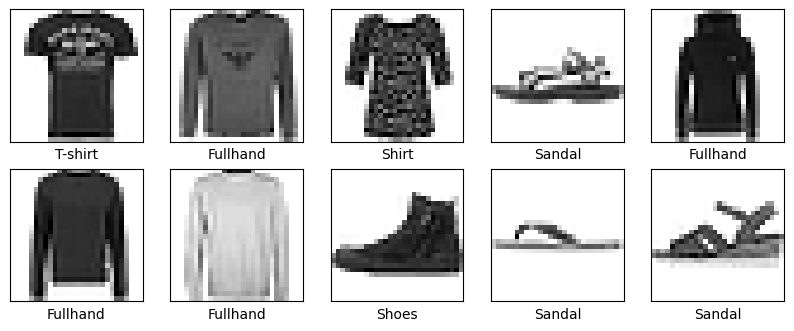

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

def load_mnist_images(file_path):
    with open(file_path, 'rb') as file:
        data = np.frombuffer(file.read(), dtype=np.uint8)

        magic_number = data[0:4].view('>i4')[0]
        num_images = data[4:8].view('>i4')[0]
        rows = data[8:12].view('>i4')[0]     
        cols = data[12:16].view('>i4')[0]
        

        images = data[16:].reshape(num_images, rows, cols)
        return images


def load_mnist_labels(file_path):
    with open(file_path, 'rb') as file:
        data = np.frombuffer(file.read(), dtype=np.uint8)
        
        magic_number = data[0:4].view('>i4')[0]
        num_labels = data[4:8].view('>i4')[0]
        
        labels = data[8:]
        return labels


# Load the training, validtion data
image_data = load_mnist_images('../../data/external/fashion_mnist/train-images-idx3-ubyte')
label_data = load_mnist_labels('../../data/external/fashion_mnist/train-labels-idx1-ubyte')

np.random.seed(0)

indices = np.arange(image_data.shape[0])
np.random.shuffle(indices)
image_data = image_data[indices]
label_data = label_data[indices]

split = int(image_data.shape[0] * 0.85)
train_images, val_images = image_data[:split], image_data[split:]
train_labels, val_labels = label_data[:split], label_data[split:]

# Load the test data
test_images = load_mnist_images('../../data/external/fashion_mnist/t10k-images-idx3-ubyte')
test_labels = load_mnist_labels('../../data/external/fashion_mnist/t10k-labels-idx1-ubyte')


# Load the class names from the label data
class_names = ['T-shirt', 'Pant', 'Fullhand', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Shoes']

print('Data processing complete.')


# Visualize the data
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show()


# Load into dataloader
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0
        image = np.expand_dims(image, axis=0)
        label = self.labels[idx]
        return image, label
    
train_dataset = FashionMNISTDataset(train_images, train_labels)
val_dataset = FashionMNISTDataset(val_images, val_labels)
test_dataset = FashionMNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the model
def train_model(model, train_loader, val_loader, epochs):
    model.train()
    trainloss_list = []
    validationloss_list = []

    if model.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=model.learning_rate)
    elif model.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=model.learning_rate)
    else:
        raise ValueError('Invalid optimizer')
    
    loss_function = nn.MSELoss()
    
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        val_loss = evaluate_model(model, val_loader, loss_function)
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            optimizer.zero_grad()
            output = model.forward(images)
            loss = loss_function(output, images)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        trainloss_list.append(epoch_loss/len(train_loader.dataset))
        validationloss_list.append(val_loss)
        print(f'Epoch: {epoch}, Training_loss: {epoch_loss/len(train_loader.dataset)}, Validation_loss: {val_loss}')
    
    return trainloss_list, validationloss_list

    
def evaluate_model(model, val_loader, loss_function):
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            output = model.forward(images)
            loss = loss_function(output, images)
            val_loss += loss.item()
        
        return val_loss/len(val_loader.dataset)

In [4]:
import sys
sys.path.append('../..')
from models.Autoencoders.cnn_autoencoder import CNN_Autoencoder

filters = [4, 16]
model1 = CNN_Autoencoder(6, 2, filters, 10, 'adam', 0.01)
model1.to(device)
a, b = train_model(model1, train_loader, val_loader, 5)

Epoch: 1, Training_loss: 0.001016152107321164, Validation_loss: 0.005170236867335107
Epoch: 2, Training_loss: 0.0007532271222375771, Validation_loss: 0.0007631589201175504
Epoch: 3, Training_loss: 0.0007309509382455372, Validation_loss: 0.0007307350881811646
Epoch: 4, Training_loss: 0.0007162041177827061, Validation_loss: 0.0007560424370070298
Epoch: 5, Training_loss: 0.0007103192562639129, Validation_loss: 0.0007366764448169205


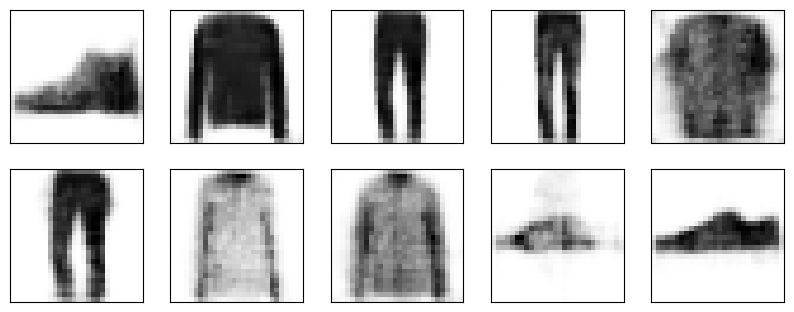

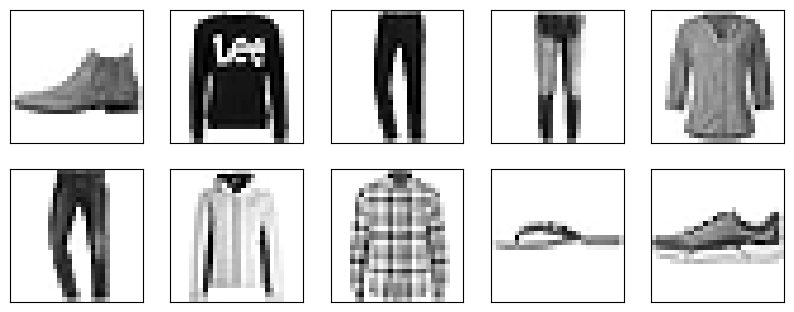

In [5]:
# Visualize the output

image, label = next(iter(test_loader))
image = image.to(device)
output = model1.forward(image)

# Visualize the output
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(output[i][0].cpu().detach().numpy(), cmap=plt.cm.binary)
plt.show()


# Visualize the original image
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[i][0].cpu().detach().numpy(), cmap=plt.cm.binary)

plt.show()

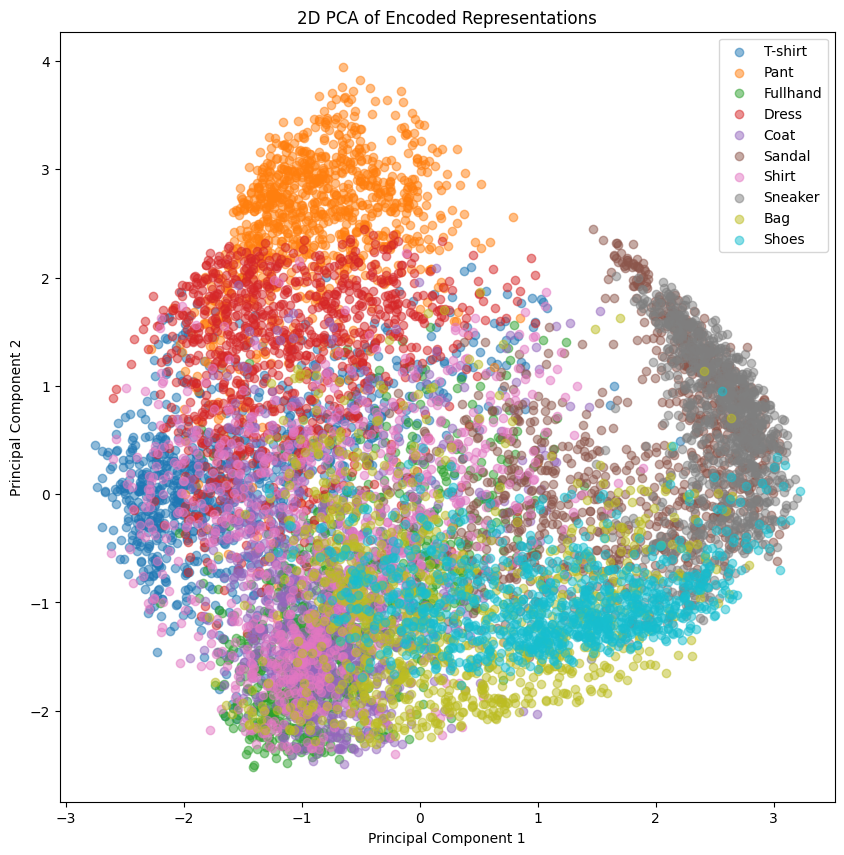

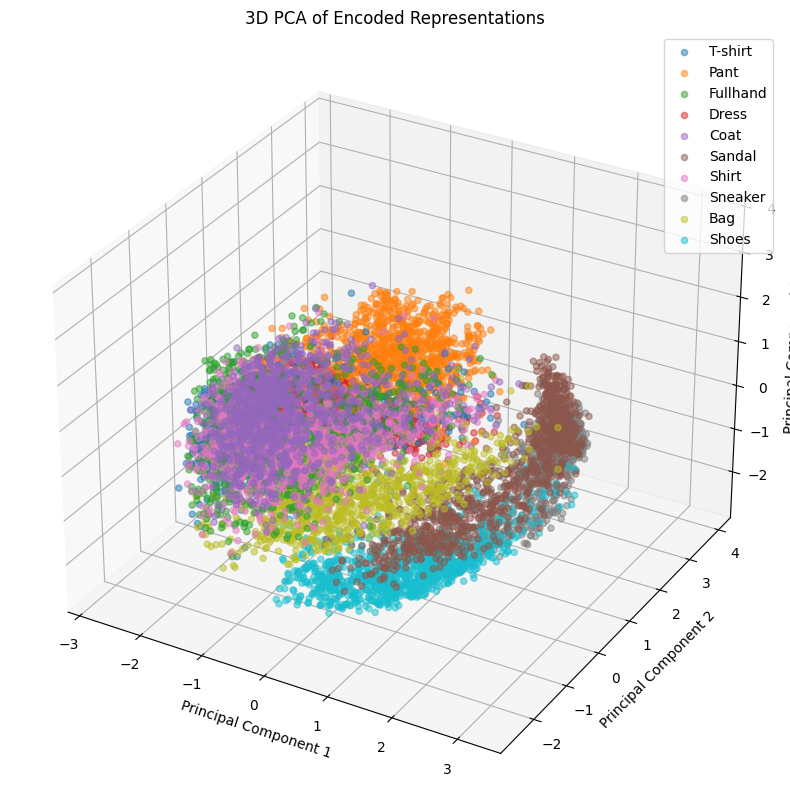

In [6]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Get the encoded representations
encoded_images = []
encoded_labels = []

model1.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        encoded = model1.encode(images).view(images.size(0), -1)
        encoded_images.append(encoded.cpu().numpy())
        encoded_labels.append(labels.cpu().numpy())

encoded_images = np.concatenate(encoded_images)
encoded_labels = np.concatenate(encoded_labels)

# Apply PCA to reduce dimensionality to 2D
pca_2d = PCA(n_components=2)
encoded_2d = pca_2d.fit_transform(encoded_images)

# Apply PCA to reduce dimensionality to 3D
pca_3d = PCA(n_components=3)
encoded_3d = pca_3d.fit_transform(encoded_images)

# Plot 2D representationprint('decoder here')
plt.figure(figsize=(10, 10))
for i in range(10):
    indices = encoded_labels == i
    plt.scatter(encoded_2d[indices, 0], encoded_2d[indices, 1], label=class_names[i], alpha=0.5)
plt.legend()
plt.title('2D PCA of Encoded Representations')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Plot 3D representation
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(10):
    indices = encoded_labels == i
    ax.scatter(encoded_3d[indices, 0], encoded_3d[indices, 1], encoded_3d[indices, 2], label=class_names[i], alpha=0.5)
ax.legend()
ax.set_title('3D PCA of Encoded Representations')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

#### Observations
- In 3D plot coat, shirt, T-shirt/top, pullover, Trouser and dress are overlapping.
- In 3D plot Bag, sneakers, ankle boots and sandals are seperated from each other.
- In 3D plots coat or wearables are seperated from shoes, bags etc...
- 3D plot is very useful to visualize the data than 2D plot.

Epoch: 1, Training_loss: 0.001477595373294225, Validation_loss: 0.005848235703176922
Epoch: 2, Training_loss: 0.001116633301126022, Validation_loss: 0.0011763677870233853
Epoch: 3, Training_loss: 0.001083844572597859, Validation_loss: 0.0010735504045668576
Epoch: 4, Training_loss: 0.0010703261152421142, Validation_loss: 0.0010595326508498855
Epoch: 5, Training_loss: 0.00106062989605262, Validation_loss: 0.0010586552555776304
Epoch: 1, Training_loss: 0.003706785561699493, Validation_loss: 0.005201296198699209
Epoch: 2, Training_loss: 0.002258590417968876, Validation_loss: 0.0024494998848272696
Epoch: 3, Training_loss: 0.0018981365809107528, Validation_loss: 0.002082302221821414
Epoch: 4, Training_loss: 0.0016079138376403088, Validation_loss: 0.0017215222434865103
Epoch: 5, Training_loss: 0.001436707840757627, Validation_loss: 0.0015076602776017455
Epoch: 1, Training_loss: 0.0009336384089992327, Validation_loss: 0.005667036804887984
Epoch: 2, Training_loss: 0.0006393565884334784, Validat

Text(0.5, 1.0, 'Validation Loss for Different Parameters')

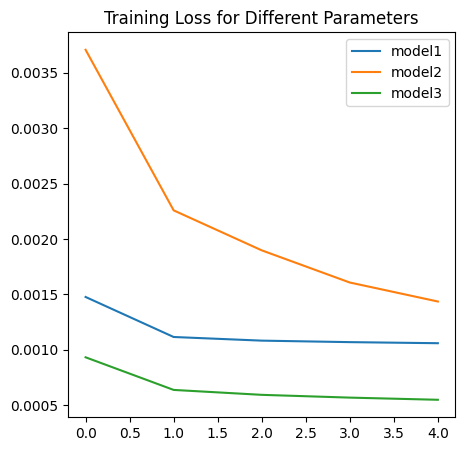

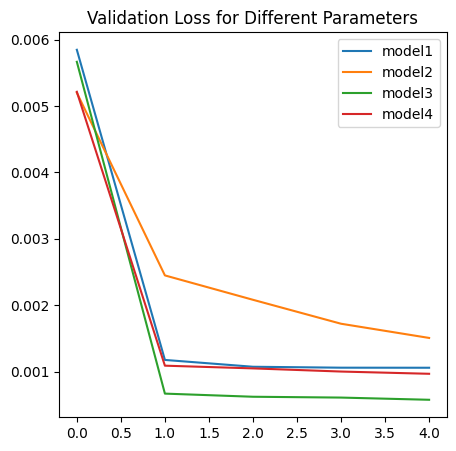

In [12]:
# Hyper parameter tuning

import sys
sys.path.append('../..')
from models.Autoencoders.cnn_autoencoder import CNN_Autoencoder

trainloss_list = []
valloss_list = []

filters = [4, 16]
model1 = CNN_Autoencoder(6, 2, filters, 10, 'adam', 0.01)
model1.to(device)
train_list, val_list = train_model(model1, train_loader, val_loader, 5)
trainloss_list.append(train_list)
valloss_list.append(val_list)

model2 = CNN_Autoencoder(6, 2, filters, 10, 'sgd', 0.01)
model2.to(device)
train_list, val_list = train_model(model2, train_loader, val_loader, 5)
trainloss_list.append(train_list)
valloss_list.append(val_list)

filters = [4, 16, 32]
model3 = CNN_Autoencoder(6, 3, filters, 10, 'adam', 0.001)
model3.to(device)
train_list, val_list = train_model(model3, train_loader, val_loader, 5)
trainloss_list.append(train_list)
valloss_list.append(val_list)

filters = [4, 16]
model4 = CNN_Autoencoder(14, 2, filters, 10, 'adam', 0.01)
model4.to(device)
train_list, val_list = train_model(model4, train_loader, val_loader, 5)
trainloss_list.append(train_list)
valloss_list.append(val_list)

# plot the training and validation loss
plt.figure(figsize=(5, 5))
for i in range(4):
    plt.plot(trainloss_list[i], label=f'model{i+1}')
plt.legend()
plt.title('Training Loss for Different Parameters')

plt.figure(figsize=(5, 5))
for i in range(4):
    plt.plot(valloss_list[i], label=f'model{i+1}')
plt.legend()
plt.title('Validation Loss for Different Parameters')

#### Conclusion
- Adam optimizer is the best optimizer than SGD.
- Using more number of layers and neurons in the model is better.
- Using filter size as 14 is also good as filter size 6.
- Also using lr = 0.001 is no such difference lr = 0.01.

Epoch: 1, Training_loss: 0.0010250243143196784, Validation_loss: 0.0010176686762521665
Epoch: 2, Training_loss: 0.0010235691899251119, Validation_loss: 0.0010068328322635756
Epoch: 3, Training_loss: 0.001020294539228666, Validation_loss: 0.0010269112386223343
Epoch: 4, Training_loss: 0.001021278034055642, Validation_loss: 0.0010253516085859803
Epoch: 5, Training_loss: 0.0010207066729883937, Validation_loss: 0.0010451261966178814
Epoch: 1, Training_loss: 0.0011254877607319868, Validation_loss: 0.0011171283216940033
Epoch: 2, Training_loss: 0.0011035152562327828, Validation_loss: 0.0010933297895308997
Epoch: 3, Training_loss: 0.0010841427319774441, Validation_loss: 0.0010722743624614346
Epoch: 4, Training_loss: 0.0010676756903310032, Validation_loss: 0.0010545433902492125
Epoch: 5, Training_loss: 0.0010529753214807488, Validation_loss: 0.001039610480889678
Epoch: 1, Training_loss: 0.0005057264470915292, Validation_loss: 0.0005192680238849587
Epoch: 2, Training_loss: 0.0004990494608988656

Text(0.5, 1.0, 'Validation Loss for Best model vs No of Layers')

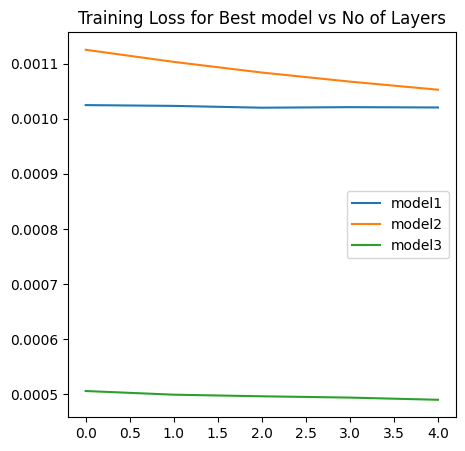

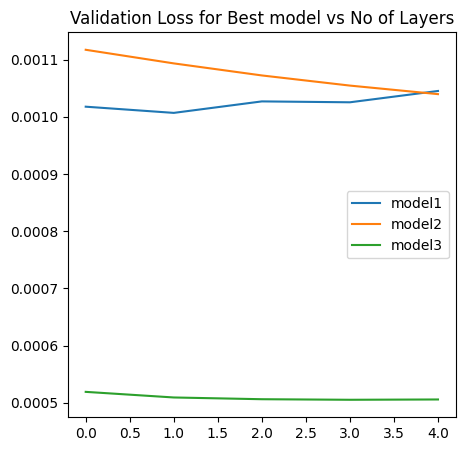

In [16]:
# Keep latent dimension constant and vary no of layers
trainloss_list = []
valloss_list = []

filters = [4, 16]
optimal_model1 = CNN_Autoencoder(6, 2, filters, 10, 'adam', 0.001)
optimal_model1.to(device)
train_list, val_list = train_model(model1, train_loader, val_loader, 5)
trainloss_list.append(train_list)
valloss_list.append(val_list)

filters = [4, 16, 32]
optimal_model2 = CNN_Autoencoder(6, 3, filters, 10, 'adam', 0.001)
optimal_model2.to(device)
train_list, val_list = train_model(model2, train_loader, val_loader, 5)
trainloss_list.append(train_list)
valloss_list.append(val_list)

filters = [4, 16, 32, 64]
optimal_model3 = CNN_Autoencoder(6, 4, filters, 10, 'adam', 0.001)
optimal_model3.to(device)
train_list, val_list = train_model(model3, train_loader, val_loader, 5)
trainloss_list.append(train_list)
valloss_list.append(val_list)

# plot the training and validation loss
plt.figure(figsize=(5, 5))
for i in range(3):
    plt.plot(trainloss_list[i], label=f'model{i+1}')
plt.legend()
plt.title('Training Loss for Best model vs No of Layers')

plt.figure(figsize=(5, 5))
for i in range(3):
    plt.plot(valloss_list[i], label=f'model{i+1}')

plt.legend()
plt.title('Validation Loss for Best model vs No of Layers')

#### Conclusion
- Model with more number of layers and neurons is better.
- model3 > model2 > model1

In [ ]:
# Auto encoder using MLP

import sys
sys.path.append('../..')
from models.AutoEncoders.AutoEncoders import Autoencoders

x = train_loader.dataset.images.reshape(-1, 28*28)

MLP_Autoencoder = Autoencoders(3, [100, 50, 100], ['relu', 'linear' ,'relu', 'tanh'])
MLP_Autoencoder.fit(x, x, 'batch', 'MSE', 0.01, 10, 100)

# Visualize the output
image, label = next(iter(test_loader))
output = MLP_Autoencoder.forward(image.view(image.size(0), -1))

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(output[i].view(28, 28))

plt.show()

# Visualize the original image
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[i][0])

plt.show()

Number of components: 0, Validation Loss: 5624.96404208489
Number of components: 1, Validation Loss: 3987.9880638769732
Number of components: 2, Validation Loss: 2999.080922360948
Number of components: 3, Validation Loss: 2670.182735039516
Number of components: 4, Validation Loss: 2387.0032216114596
Number of components: 5, Validation Loss: 2174.5828753982246
Number of components: 6, Validation Loss: 1974.9653043670128
Number of components: 7, Validation Loss: 1843.4428440609086
Number of components: 8, Validation Loss: 1734.2234921824231
Number of components: 9, Validation Loss: 1661.0808675756637
Number of components: 10, Validation Loss: 1587.8732324735556
Number of components: 11, Validation Loss: 1530.8908651933502
Number of components: 12, Validation Loss: 1478.7613406441017
Number of components: 13, Validation Loss: 1436.346513014854
Number of components: 14, Validation Loss: 1399.6292510348107
Number of components: 15, Validation Loss: 1364.9757849686762
Number of components: 1

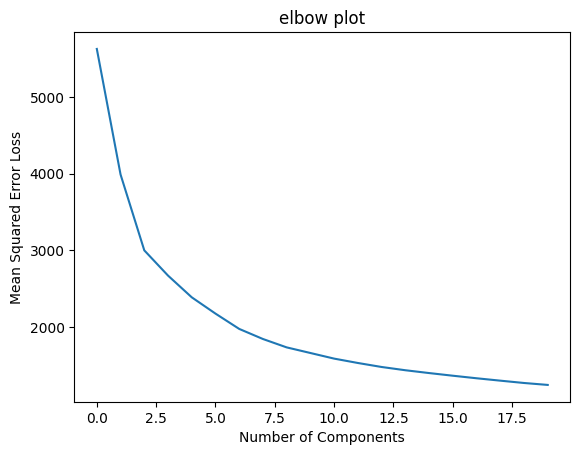

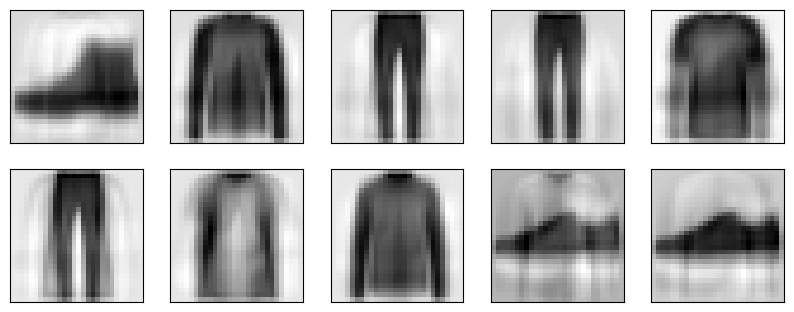

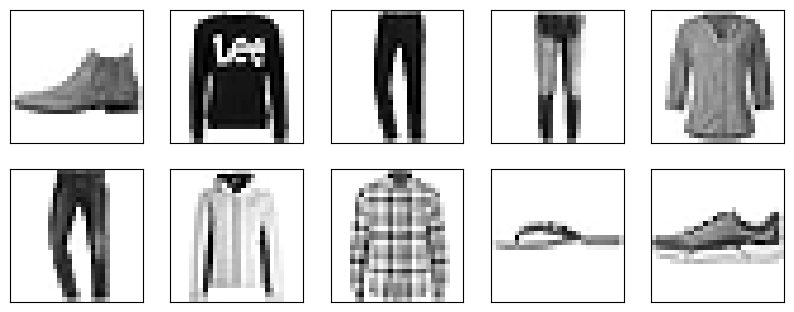

In [10]:
# Autoencoder using PCA
import sys
import torch
sys.path.append('../..')
from models.Autoencoders.pca_autoencoder import PCA_Autoencoder

train_data = train_loader.dataset.images.reshape(-1, 28*28)
validation_data = val_loader.dataset.images.reshape(-1, 28*28)
test_data = test_loader.dataset.images.reshape(-1, 28*28)


loss_values = []
for i in range(20):
    pca_AE = PCA_Autoencoder(i)
    pca_AE.fit(train_data)
    reconstructed_data = pca_AE.forward(validation_data)
    mse_loss = np.mean(np.square(validation_data - reconstructed_data))
    print(f'Number of components: {i}, Validation Loss: {mse_loss}')
    loss_values.append(mse_loss)

plt.plot(range(20), loss_values)
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error Loss')
plt.title('elbow plot')
plt.show()

k_optimal = 10

optimal_pca_AE = PCA_Autoencoder(k_optimal)
optimal_pca_AE.fit(train_data)
reconstructed_data = optimal_pca_AE.forward(test_data)

# Visualize the output
image, label = next(iter(test_loader))
output = torch.tensor(reconstructed_data).view(-1, 1, 28, 28)

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(output[i].view(28, 28), plt.cm.binary)

plt.show()

# Visualize the original image
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[i][0], plt.cm.binary)


#### Observations
- From the above Elbow method, we can see that the optimal number of clusters is 10.
- As we compared it with CNN auto-encoder, we can see that PCA auto-encoder is not able to reconstruct images properly. But PCA is more faster than CNN.

In [11]:
# Find the encoded representations for all CNN, PCA, MLP autoencoders
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
sys.path.append('../..')
from models.Autoencoders.cnn_autoencoder import CNN_Autoencoder
from models.Autoencoders.pca_autoencoder import PCA_Autoencoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = train_loader.dataset.images.reshape(-1, 28*28)
train_labels = train_loader.dataset.labels
validation_data = val_loader.dataset.images.reshape(-1, 28*28)
validation_labels = val_loader.dataset.labels
test_data = test_loader.dataset.images.reshape(-1, 28*28)
test_labels = test_loader.dataset.labels


# CNN Autoencoder
encoded_train_images = []
encoded_train_labels = []
encoded_test_images = []
encoded_test_labels = []

CNN_model = CNN_Autoencoder(2, 2, [4, 16], 10, 'adam', 0.001)
CNN_model.to(device)
train_model(CNN_model, train_loader, val_loader, 5)

# encode the train images with corresponding labels
CNN_model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        encoded = CNN_model.encode(images).view(images.size(0), -1)
        encoded_train_images.append(encoded.cpu().numpy())
        encoded_train_labels.append(labels.cpu().numpy())

# encode the test images with corresponding labels
CNN_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        encoded = CNN_model.encode(images).view(images.size(0), -1)
        encoded_test_images.append(encoded.cpu().numpy())
        encoded_test_labels.append(labels.cpu().numpy())

encoded_train_images_cnn = np.concatenate(encoded_train_images)
encoded_train_labels_cnn = np.concatenate(encoded_train_labels)

encoded_test_images_cnn = np.concatenate(encoded_test_images)
encoded_test_labels_cnn = np.concatenate(encoded_test_labels)

print(encoded_test_images_cnn.shape, encoded_test_labels_cnn.shape)


# PCA Autoencoder
k_optimal = 10
PCA_model = PCA_Autoencoder(k_optimal)
PCA_model.fit(train_data)
encoded_train_images_pca = PCA_model.encode(train_data)
encoded_train_labels_pca = train_labels
encoded_test_images_pca = PCA_model.encode(test_data)
encoded_test_labels_pca = test_labels


# MLP Autoencoder
x = test_loader.dataset.images.reshape(-1, 28*28)
# encoded_images_mlp = MLP_Autoencoder.forward(x)

Epoch: 1, Training_loss: 0.0010423066168293064, Validation_loss: 0.004916290390822623
Epoch: 2, Training_loss: 0.0007685431123656385, Validation_loss: 0.0008004527795645926
Epoch: 3, Training_loss: 0.0007343511783024844, Validation_loss: 0.0007532580234110355
Epoch: 4, Training_loss: 0.0007137551002350508, Validation_loss: 0.0007293728424443139
Epoch: 5, Training_loss: 0.0006991631785298095, Validation_loss: 0.0007136154472827911
(10000, 10) (10000,)


CNN Autoencoder Test Accuracy: 0.755
PCA Autoencoder Test Accuracy: 0.8122
CNN Autoencoder Train Accuarcy: 0.8011176470588235
PCA Autoencoder Train Accuracy: 0.8465098039215686


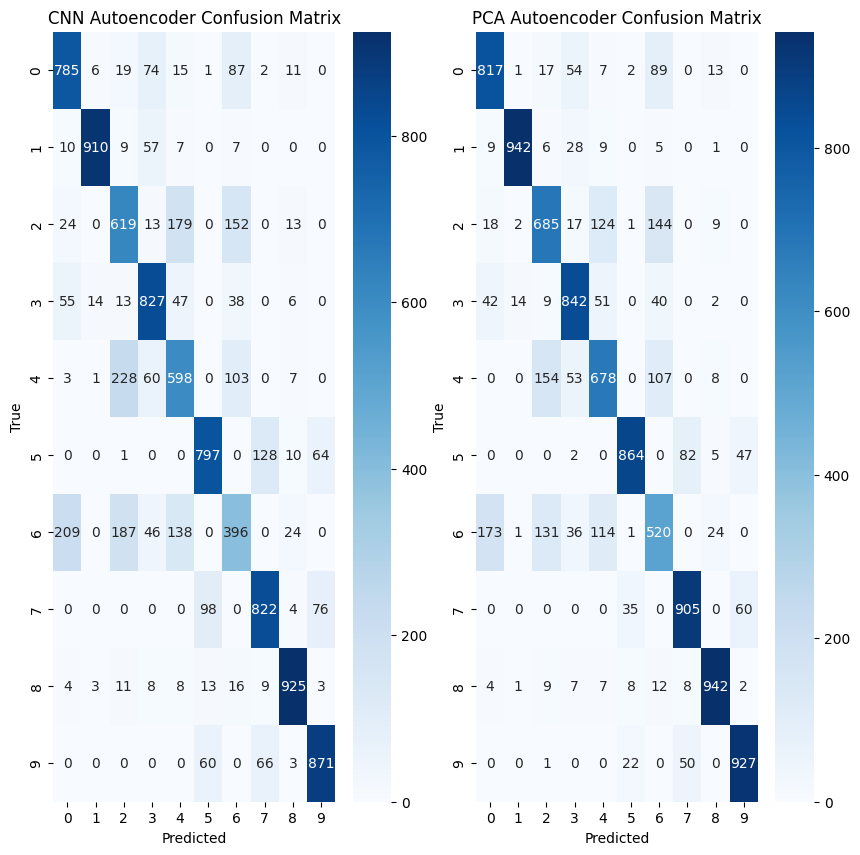

In [13]:
# KNN classifier on the encoded representations

# CNN Autoencoder
from models.knn.knn import KNN_optim

knn_cnn = KNN_optim(10, 'manhattan')
knn_cnn.train_model(encoded_train_images_cnn, encoded_train_labels_cnn)

# PCA Autoencoder
knn_pca = KNN_optim(10, 'manhattan')
knn_pca.train_model(encoded_train_images_pca, encoded_train_labels_pca)

def confusion_matrix(y_true, y_pred, num_classes):
    matrix = np.zeros((num_classes, num_classes))
    for i in range(len(y_true)):
        matrix[y_true[i]][y_pred[i]] += 1
    return matrix

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


y_pred_cnn = knn_cnn.predict(encoded_test_images_cnn)
conf_matrix_cnn = confusion_matrix(encoded_test_labels_cnn, y_pred_cnn, 10)

y_pred_pca = knn_pca.predict(encoded_test_images_pca)
conf_matrix_pca = confusion_matrix(encoded_test_labels_pca, y_pred_pca, 10)

y_pred_train_cnn = knn_cnn.predict(encoded_train_images_cnn)
y_pred_train_pca = knn_pca.predict(encoded_train_images_pca)

print(f'CNN Autoencoder Test Accuracy: {accuracy(encoded_test_labels_cnn, y_pred_cnn)}')
print(f'PCA Autoencoder Test Accuracy: {accuracy(encoded_test_labels_pca, y_pred_pca)}')

print(f'CNN Autoencoder Train Accuarcy: {accuracy(encoded_train_labels_cnn, y_pred_train_cnn)}')
print(f'PCA Autoencoder Train Accuracy: {accuracy(encoded_train_labels_pca, y_pred_train_pca)}')

# Visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_cnn, annot=True, cmap='Blues', fmt='g')
plt.title('CNN Autoencoder Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_pca, annot=True, cmap='Blues', fmt='g')
plt.title('PCA Autoencoder Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

#### Observations
- The performance is generally similar for classes like 1, 7, 8, and 9 across both autoencoders, with high diagonal values indicating correct predictions. These classes may have more distinct features, making them easier for both models to reconstruct accurately.

- There are differences in the handling of classes with more variability or overlap, like classes 6 and 5, where both models show a wider spread of misclassifications.